<a href="https://colab.research.google.com/github/suharjin01/Prediksi-Covid-19-Berdasarkan-Citra-X-Ray-Menggunakan-CNN/blob/main/Prediksi-Covid-19-Berdasarkan-Citra-X-Ray-Menggunakan-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

In [ ]:
# Cek versi tensorflow
print(tf.__version__)

2.5.0


In [ ]:
#meload data dari google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/MyDrive'

/content/drive/MyDrive


In [ ]:
import zipfile,os
local_zip = '/content/drive/MyDrive/covid.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('cvd')
zip_ref.close()

In [ ]:
#install splitfolders
!pip install split_folders

In [ ]:
import splitfolders
splitfolders.ratio('cvd', 'cvd/data', seed=1, ratio=(.8, .2))

Copying files: 3886 files [00:56, 69.22 files/s]


In [ ]:
base_dir = 'cvd/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
os.listdir('cvd/data/train')
os.listdir('cvd/data/val')

['COVID', 'NORMAL', 'Viral Pneumonia']

In [ ]:
#cek berapa image yang terdapat pada masing-masing directory
len(os.listdir('cvd/data/train/COVID'))

960

In [ ]:
len(os.listdir('cvd/data/train/Viral Pneumonia'))

1076

In [ ]:
len(os.listdir('cvd/data/train/NORMAL'))

1072

In [ ]:
len(os.listdir('cvd/data/val/COVID'))

240

In [ ]:
len(os.listdir('cvd/data/val/Viral Pneumonia'))

269

In [ ]:
len(os.listdir('cvd/data/val/NORMAL'))

269

In [ ]:
#membuat direktory
train_covid_dir = os.path.join(train_dir, 'COVID')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_pneumonia_dir = os.path.join(validation_dir, 'Viral Pneumonia')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

In [ ]:
#membuat image generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 3108 images belonging to 3 classes.
Found 778 images belonging to 3 classes.


In [ ]:
#membuat model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

In [ ]:
#Membuat fungsi Callback
class FungsiCallback(tf.keras.callbacks.Callback):
  def epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95) and (logs.get('loss') <= 0.2 and logs.get('val_loss') <= 0.2):
      self.model.stop_training = True
    else:
      self.model.stop_training = False

fungsi_cb = FungsiCallback()
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model.h5')

In [ ]:
# Compile model dengan 'adam' optimizer loss function 'binary_crossentropy'
model.compile(loss = 'categorical_crossentropy',
             optimizer = tf.optimizers.Adam(),
             metrics = ['accuracy'])

In [ ]:
#latih model
history = model.fit(
    train_generator,
    steps_per_epoch = 25,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 5,
    verbose = 2,
    callbacks = [fungsi_cb, checkpoint_cb]
)

Epoch 1/20
25/25 - 52s - loss: 1.1034 - accuracy: 0.3638 - val_loss: 0.9750 - val_accuracy: 0.4375
Epoch 2/20
25/25 - 16s - loss: 0.6298 - accuracy: 0.7200 - val_loss: 0.4099 - val_accuracy: 0.8500
Epoch 3/20
25/25 - 17s - loss: 0.5571 - accuracy: 0.7837 - val_loss: 0.4614 - val_accuracy: 0.8000
Epoch 4/20
25/25 - 17s - loss: 0.4192 - accuracy: 0.8300 - val_loss: 0.2670 - val_accuracy: 0.9062
Epoch 5/20
25/25 - 17s - loss: 0.3640 - accuracy: 0.8612 - val_loss: 0.3474 - val_accuracy: 0.8687
Epoch 6/20
25/25 - 17s - loss: 0.3648 - accuracy: 0.8512 - val_loss: 0.3215 - val_accuracy: 0.9000
Epoch 7/20
25/25 - 18s - loss: 0.3318 - accuracy: 0.8838 - val_loss: 0.3130 - val_accuracy: 0.9000
Epoch 8/20
25/25 - 16s - loss: 0.2727 - accuracy: 0.9175 - val_loss: 0.2265 - val_accuracy: 0.9125
Epoch 9/20
25/25 - 16s - loss: 0.2147 - accuracy: 0.9275 - val_loss: 0.3647 - val_accuracy: 0.8750
Epoch 10/20
25/25 - 16s - loss: 0.2818 - accuracy: 0.9125 - val_loss: 0.2729 - val_accuracy: 0.9000
Epoch 11/

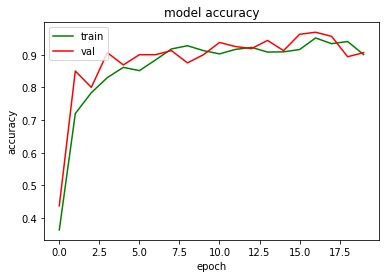

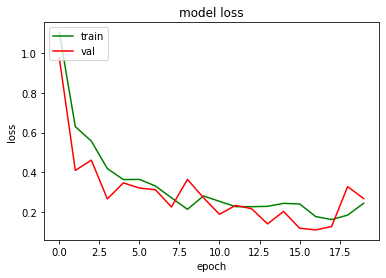

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, color='green')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss, color='green')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Saving COVID (28).png to COVID (28).png
COVID (28).png
Positif Covid 19


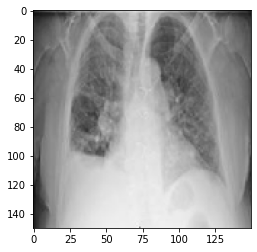

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()
for fn in uploaded.keys():
    
    #prediksi image
    path = fn
    img = image.load_img(path, target_size = (150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    image = np.vstack([x])
    classes = model.predict(image, batch_size = 32)
    
    print(fn)
    if classes[0,0] != 0:
        print('Positif Covid 19')
    elif classes[0,1] != 0:
        print('Normal')
    else:
        print('Pneumonia')

In [ ]:
# menyimpan model
model.save('model.h5')

In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp91e9q7eo/assets


In [ ]:
# menyimpan model ke dalam format TF-Lite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)